<h1>Regression Model</h1>

Creation of a Random Forest Regressor using hypertuning with grid search, validation and error analysis, to predict total stay days of a hotel dataset.

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.regressor import PredictionError, ResidualsPlot
from ipynb.fs.full.funPyModeling import status, freq_tbl

<h3>Data Loading</h3>

In [3]:
data=pd.read_csv("data/hotels.csv", sep = ",")

<h3>Target and Features Preparation</h3>

In [4]:
data2 = data[['total_of_special_requests','deposit_type','customer_type', 'stays_in_weekend_nights',
              'stays_in_week_nights', 'required_car_parking_spaces','arrival_date_month',
              'arrival_date_day_of_month','hotel']].copy()

Target variable

In [5]:
data2['total_stay'] = data2['stays_in_week_nights'] + data2['stays_in_weekend_nights']

In [6]:
data3 = data2.drop(['stays_in_week_nights','stays_in_weekend_nights'], axis=1)

<h3>Dataset Status</h3>

In [7]:
status(data3)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,total_of_special_requests,0,0.0,70318,0.588977,6,int64
1,deposit_type,0,0.0,0,0.000000,3,object
2,customer_type,0,0.0,0,0.000000,4,object
3,required_car_parking_spaces,0,0.0,111974,0.937884,5,int64
4,arrival_date_month,0,0.0,0,0.000000,12,object
5,arrival_date_day_of_month,0,0.0,0,0.000000,31,int64
6,hotel,0,0.0,0,0.000000,2,object
7,total_stay,0,0.0,715,0.005989,45,int64


In this dataset there arent NaNs. There are 4 categorical variables ('deposit_type', 'customer_type', 'arrival_date_month' and 'hotel') and 4 numerical variables ('total_of_special_requests', 'required_car_parking_spaces', 'arrival_date_day_of_month', 'total_stay')

In [8]:
freq_tbl(data3)

  deposit_type  frequency  percentage  cumulative_perc
0   No Deposit     104641    0.876464         0.876464
1   Non Refund      14587    0.122179         0.998643
2   Refundable        162    0.001357         1.000000

----------------------------------------------------------------

     customer_type  frequency  percentage  cumulative_perc
0        Transient      89613    0.750591         0.750591
1  Transient-Party      25124    0.210436         0.961027
2         Contract       4076    0.034140         0.995167
3            Group        577    0.004833         1.000000

----------------------------------------------------------------

   arrival_date_month  frequency  percentage  cumulative_perc
0              August      13877    0.116233         0.116233
1                July      12661    0.106047         0.222280
2                 May      11791    0.098760         0.321040
3             October      11160    0.093475         0.414515
4               April      11089    0.092

Index(['deposit_type', 'customer_type', 'arrival_date_month', 'hotel'], dtype='object')

array([[<AxesSubplot:title={'center':'total_of_special_requests'}>,
        <AxesSubplot:title={'center':'required_car_parking_spaces'}>],
       [<AxesSubplot:title={'center':'arrival_date_day_of_month'}>,
        <AxesSubplot:title={'center':'total_stay'}>]], dtype=object)

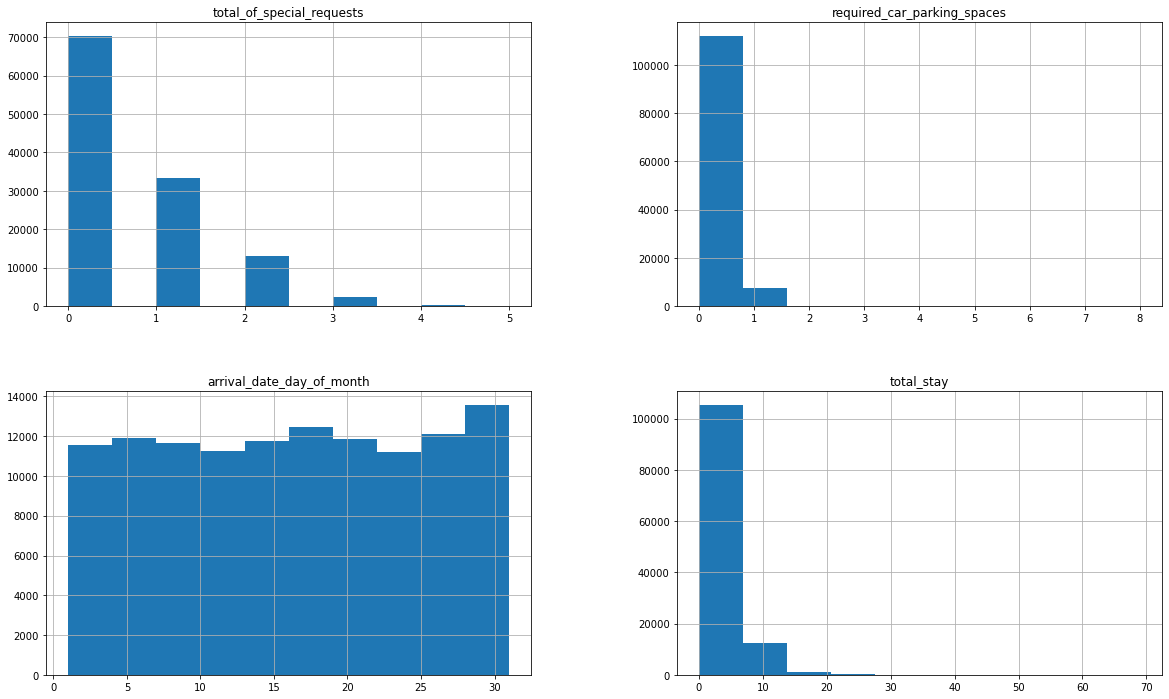

In [9]:
data3.hist(figsize=(20, 12))

From the histograms, i see that could be outliers in 'total_stay'

<h3>Data Preparation</h3>

In [10]:
data4 = pd.get_dummies(data3, drop_first=True)

In [11]:
x_data=data4.drop('total_stay', axis=1)
y_data=data4['total_stay']

Training set and test set separation

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

<h3>Model Creation (Random Forest with hypertuning using grid_search)</h3>

In [13]:
model_rf = RandomForestRegressor()

In [14]:
params = {
    'n_estimators' : [100, 200, 500, 1000],
    'max_features': [2,3]
}

grid_rf = GridSearchCV(estimator = model_rf,
                        param_grid = params,
                        scoring = 'neg_mean_absolute_error',  # 
                        cv = 5, 
                        verbose = 1,
                        n_jobs = -1)

In [15]:
grid_rf.fit(x_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 24.5min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_features': [2, 3],
                         'n_estimators': [100, 200, 500, 1000]},
             scoring='neg_mean_absolute_error', verbose=1)

New cases prediction

In [16]:
grid_rf.predict(x_train)
grid_rf.predict(x_test)

array([1.98473756, 3.91674672, 3.32318532, ..., 2.25448789, 2.84637366,
       2.47086219])

<h3>Error metrics</h3>

In [17]:
pd.concat([pd.DataFrame(grid_rf.cv_results_["params"]),
           pd.DataFrame(grid_rf.cv_results_["mean_test_score"], 
                        columns=["neg_mean_absolute_error"])],axis=1).sort_values('neg_mean_absolute_error', ascending=False)

,max_features,n_estimators,neg_mean_absolute_error
3,2,1000,-1.425512
6,3,500,-1.425713
7,3,1000,-1.425735
5,3,200,-1.425883
2,2,500,-1.425887
1,2,200,-1.425958
0,2,100,-1.426263
4,3,100,-1.426508


In [18]:
grid_rf.score(x_train, y_train)

-1.2832235502645675

In [19]:
grid_rf.score(x_test, y_test)

-1.40498108251426

The scores are very similar for training and test, so the model has a good performance.

<h3>Error graphics</h3>

Prediction error graphic

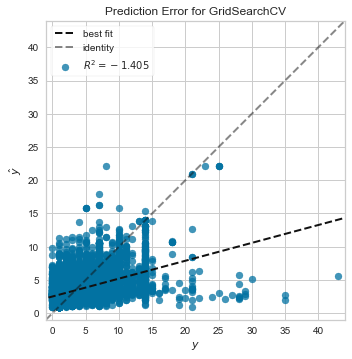

<AxesSubplot:title={'center':'Prediction Error for GridSearchCV'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [21]:
vis_pred_err = PredictionError(grid_rf)

vis_pred_err.fit(x_train, y_train)
vis_pred_err.score(x_test, y_test)
vis_pred_err.show()

Residual plot

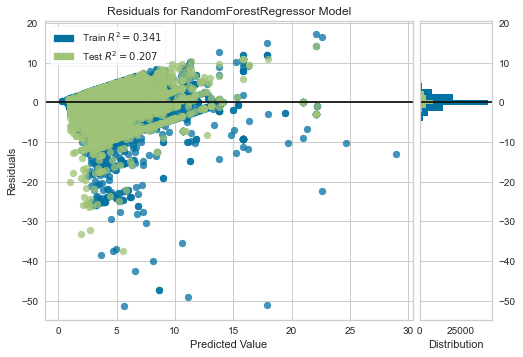

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [23]:
vis_res = ResidualsPlot(grid_rf.best_estimator_)

vis_res.fit(x_train, y_train)
vis_res.score(x_test, y_test)
vis_res.show()

The error follows a normal distribution distribution is centered at 0, where it has the greatest number of points (this is desired). Also, there are a little big errors.